<a href="https://colab.research.google.com/github/KauaHenSilva/python_identifies_human/blob/main/deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [132]:
import cv2
import dlib
import imutils
import os
from PIL import Image
import numpy as np
import google.colab.drive as drive
from google.colab.patches import cv2_imshow

In [133]:
# drive: https://drive.google.com/drive/folders/1OXTbhGlG6Y-x6hMY_5Y8Ed3mPB9lP5LF?usp=sharing
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Detecção Face

In [134]:
prototxt = "/content/drive/MyDrive/Face Detection and Recognition/weights/deploy.prototxt.txt"
model = "/content/drive/MyDrive/Face Detection and Recognition/weights/res10_300x300_ssd_iter_140000.caffemodel"
network = cv2.dnn.readNetFromCaffe(prototxt, model)

In [135]:
def pre_img_jpg(img_path):
    return cv2.imread(img_path)

def pre_img_gif(img_path):
    imagem = Image.open(img_path).convert("L")
    imagem = np.array(imagem, 'uint8')
    imagem = cv2.cvtColor(imagem, cv2.COLOR_GRAY2RGB)
    return imagem

def run_ssd_recort(net, img_path: str, ssd_size, conf_min=0.85, draw = False, max_width = 700):
    if (img_path.split('.')[-1] == 'jpg'):
      imagem = pre_img_jpg(img_path)
    else:
      imagem = pre_img_gif(img_path)

    if (imagem.shape[1] > max_width):
        imagem = imutils.resize(imagem, width=max_width)

    (h, w) = imagem.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(imagem, (ssd_size, ssd_size)), 1.0, (ssd_size, ssd_size), (104, 117, 123))
    net.setInput(blob)
    deteccoes = net.forward()

    faces = []
    confiancas = []
    rects = []

    for i in range(0, deteccoes.shape[2]):
        confianca_atual = deteccoes[0, 0, i, 2]

        if confianca_atual >= conf_min:
            text_conf = f"{(confianca_atual * 100):.2f}%"
            box = deteccoes[0, 0, i, 3:7] * np.array([w, h, w, h])
            (start_x, start_y, end_x, end_y) = box.astype(int)

            if draw:
              cv2.putText(imagem, f"{text_conf}", (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 0, lineType=cv2.LINE_AA)
              cv2.rectangle(imagem, (start_x - 1, start_y - 1), (end_x + 1, end_y + 1), (0, 255, 0), 1)

            faces.append(imagem[start_y:end_y, start_x:end_x])
            rects.append(dlib.rectangle(start_x, start_y, end_x, end_y))
            confiancas.append(confianca_atual)

    return imagem, faces, rects, confiancas


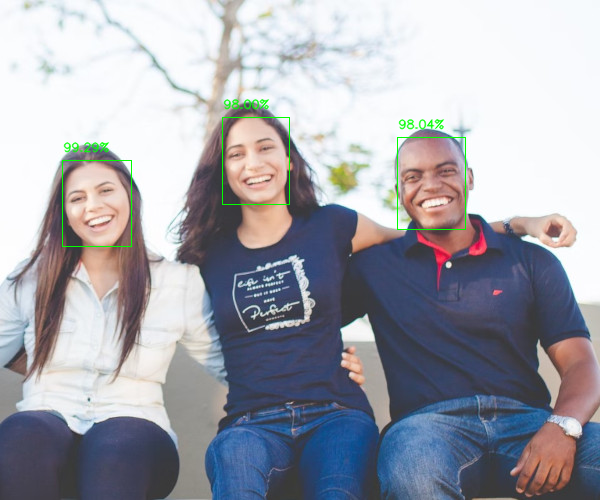

In [136]:
imagem_test = "/content/drive/MyDrive/Face Detection and Recognition/images/people2.jpg"
(img, faces, rects, confiancas) = run_ssd_recort(network, imagem_test, 300, draw= True)
cv2_imshow(img)

# Detecção de pontos faciais (landmarks)

In [137]:
dector_point = dlib.shape_predictor("/content/drive/MyDrive/Face Detection and Recognition/weights/shape_predictor_68_face_landmarks.dat")

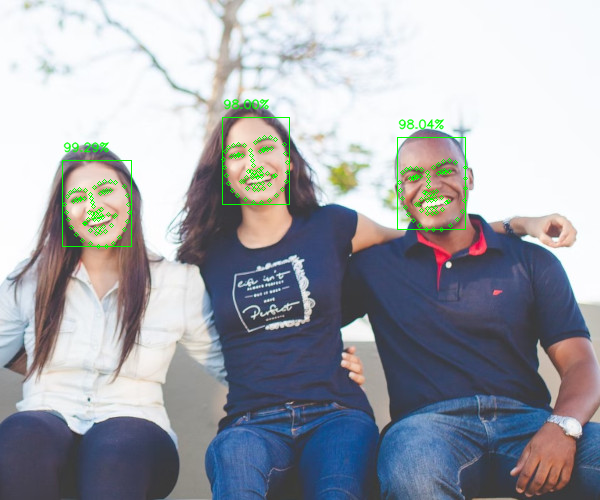

In [138]:
for rect in rects:
  pontos = dector_point(img, rect)
  for ponto in pontos.parts():
    cv2.circle(img, (ponto.x, ponto.y), 2, (0,255,0), 1)

cv2_imshow(img)

# Carregamento da base de dados

In [139]:
import zipfile

In [140]:
path = "/content/drive/MyDrive/Face Detection and Recognition/datasets/yalefaces.zip"
zip_obj = zipfile.ZipFile(path, 'r')
zip_obj.extractall('./')
zip_obj.close()

## Detecção de descritores faciais


In [141]:
extrator_descritor_facial = dlib.face_recognition_model_v1('/content/drive/MyDrive/Face Detection and Recognition/weights/dlib_face_recognition_resnet_model_v1.dat')

In [169]:
def extrai_descritor(imagem_path, ssd_size, descritores_facial=None, draw=False, multi_face=False):
    img, faces, rects, _ = run_ssd_recort(network, imagem_path, ssd_size)

    if not multi_face and len(faces) > 1:
        print("Mais de uma face detectada, não é possível extrair o descritor, path:", imagem_path)
        return img, descritores_facial, False

    for face, rect in zip(faces, rects):
        pontos = dector_point(img, rect)

        descritor_facial = extrator_descritor_facial.compute_face_descriptor(img, pontos)
        descritor_facial = np.asarray(descritor_facial, dtype=np.float64)[np.newaxis, :]

        if descritores_facial is None:
            descritores_facial = descritor_facial
        else:
            descritores_facial = np.concatenate((descritores_facial, descritor_facial), axis=0)

        if draw:
            cv2.rectangle(img, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
            for ponto in pontos.parts():
                cv2.circle(img, (ponto.x, ponto.y), 2, (0, 255, 0), 1)

    return img, descritores_facial, True

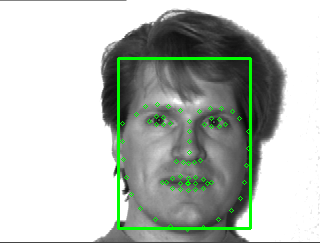

array([[-0.22915593,  0.1007781 ,  0.00084336, -0.05238041, -0.17901938,
         0.0209295 , -0.06252626, -0.07627603,  0.06015997, -0.05972954,
         0.22371653, -0.04433177, -0.3243776 , -0.11525097,  0.03503181,
         0.12400146, -0.08329622, -0.0774058 , -0.19124737, -0.06356069,
        -0.03784436,  0.00430551,  0.09867874, -0.01757284, -0.11768068,
        -0.30952626, -0.12920131,  0.01672664,  0.06882994, -0.11226055,
         0.01458806,  0.00630352, -0.16041487, -0.06833948,  0.01365794,
         0.1636842 , -0.15167493, -0.11430152,  0.23386368, -0.02615845,
        -0.15986313, -0.03373939,  0.11457124,  0.21905963,  0.21676023,
         0.01994   , -0.0084639 ,  0.00855681,  0.07859901, -0.31319973,
         0.07429998,  0.15642381,  0.1472072 ,  0.07841119,  0.09912433,
        -0.09635145,  0.02245891,  0.23090705, -0.16487607, -0.02396964,
         0.02863298, -0.06320657, -0.13258448, -0.09326261,  0.18035193,
         0.20811361, -0.12408946, -0.19530022,  0.1

In [144]:
img, descr, _= extrai_descritor("/content/yalefaces/test/subject01.gif", 100, draw=True)
cv2_imshow(img)
descr

## Base de dados treinados



In [148]:
def get_dados_treinados(ssd_size):
  paths = [os.path.join("/content/yalefaces/train", y) for y in os.listdir("/content/yalefaces/train")]
  ids = []
  descritores_face = None

  for path in paths:
    ids.append(int(path.split(".")[0].split("subject")[-1]))
    img, descritores_face, _ = extrai_descritor(path, ssd_size, descritores_face)

  return ids, descritores_face


### Salvar

In [149]:
import pickle
ids, descritores_face = get_dados_treinados(100)

np.save("descritores_face.npy", descritores_face)
with open('index_faces.pickle', 'wb') as f:
  pickle.dump(ids, f)

### Carregar

In [150]:
ids = np.load('/content/index_faces.pickle', allow_pickle=True)
descritores_face = np.load('/content/descritores_face.npy')

## Reconhecimento das faces

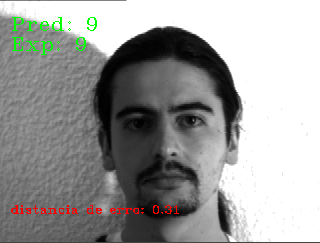

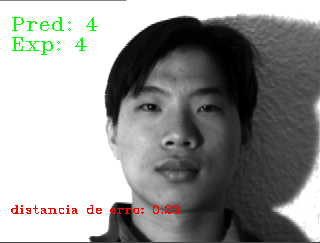

In [152]:
def previsoes(path_test, ids, descritores, ssd_size, conf = 0.5, exibir= 0):
  expecteds = []
  results = []
  paths = [os.path.join(path_test, u) for u in os.listdir(path_test)]

  for path in paths:
    (img, new_descritores, _) = extrai_descritor(path, ssd_size)

    for descritor in new_descritores:
      distancia = np.linalg.norm(descritor - descritores, axis = 1)
      min_index = np.argmin(distancia)
      distancia_minima = distancia[min_index]

      if distancia_minima <= conf:
        nome_previsao = ids[min_index]
      else:
        nome_previsao = -1

      actual_idx = int(path.split('.')[0].split("subject")[-1])
      expecteds.append(actual_idx)
      results.append(nome_previsao)

      cv2.putText(img, 'Pred: ' + str(nome_previsao), (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
      cv2.putText(img, 'Exp: ' + str(actual_idx), (10,50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
      cv2.putText(img, f"distancia de erro: {(distancia_minima):.2f}", (10, img.shape[0] - 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.6, (0,0,255))

      if exibir > 0:
        cv2_imshow(img)
        exibir -= 1

  return expecteds, results


expecteds, results = previsoes("/content/yalefaces/test", ids, descritores_face, 100, exibir=2)

In [153]:
from sklearn.metrics import accuracy_score
accuracy_score(expecteds, results)

1.0

# Disafios

In [154]:
path = "/content/drive/MyDrive/Face Detection and Recognition/datasets/celeb_dataset.zip"
zip_obj = zipfile.ZipFile(path, 'r')
zip_obj.extractall('./')
zip_obj.close()

In [155]:
ssd_size = 200

In [160]:
def get_dados_treinados(path_dir, ssd_size):
  ids = []
  descritores_face = None

  subdir = [os.path.join(path_dir, u) for u in os.listdir(path_dir)]

  for dir in subdir:
    paths = [os.path.join(dir, u) for u in os.listdir(dir)]

    for path in paths:
      img, descritores_face, add = extrai_descritor(path, ssd_size, descritores_face, draw=True)
      if add:
        ids.append(dir.split('/')[-1])

  return ids, descritores_face

ids, descritores_face = get_dados_treinados("/content/celeb_dataset/train", ssd_size)
len(ids), descritores_face.shape

Mais de uma face detectada, não é possível extrair o descritor, path: /content/celeb_dataset/train/benedict_cumberbatch/benedict05.jpg
Mais de uma face detectada, não é possível extrair o descritor, path: /content/celeb_dataset/train/dave_grohl/dave03.jpg
Mais de uma face detectada, não é possível extrair o descritor, path: /content/celeb_dataset/train/dave_grohl/dave05.jpg
Mais de uma face detectada, não é possível extrair o descritor, path: /content/celeb_dataset/train/andrew_garfield/andrew06.jpg


(51, (51, 128))

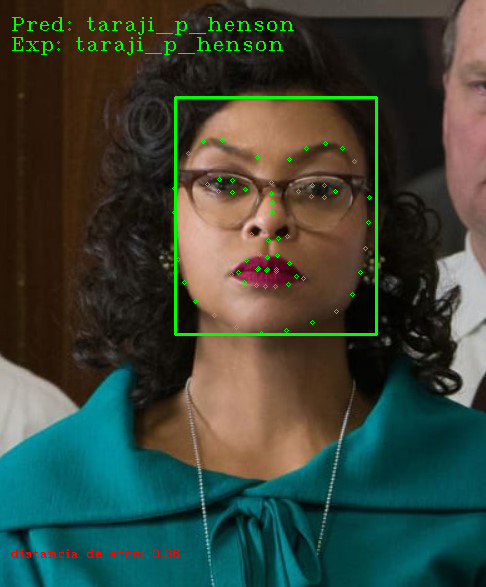

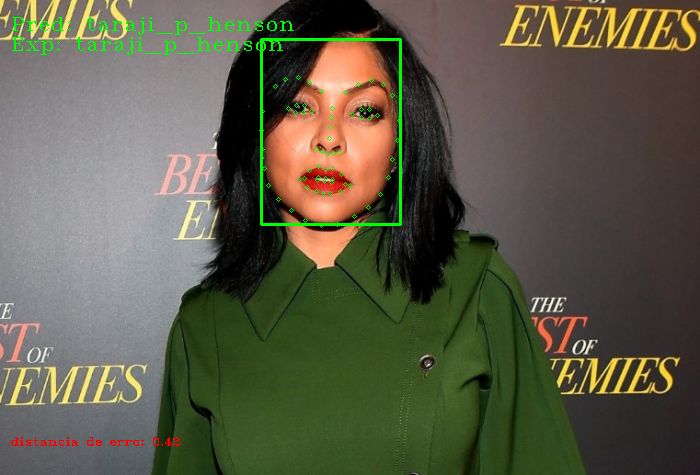

In [178]:
def previsoes(path_test, ids, descritores, ssd_size, conf = 0.5, exibir= 0, draw = False):
  expecteds = []
  results = []

  subdir = [os.path.join(path_test, u) for u in os.listdir(path_test)]

  for dir in subdir:
    paths = [os.path.join(dir, u) for u in os.listdir(dir)]

    for path in paths:
      (img, new_descritores, add) = extrai_descritor(path, ssd_size, multi_face=True, draw=draw)
      actual_idx = dir.split('/')[-1]

      if not add:
        print("Não foi possível extrair o descritor da imagem: ", path)
        expecteds.append(-1)
        results.append(actual_idx)
        continue

      for descritor in new_descritores:
        distancia = np.linalg.norm(descritor - descritores, axis = 1)
        min_index = np.argmin(distancia)
        distancia_minima = distancia[min_index]

        if distancia_minima <= conf:
          nome_previsao = ids[min_index]
        else:
          nome_previsao = -1

        expecteds.append(actual_idx)
        results.append(nome_previsao)

        cv2.putText(img, 'Pred: ' + str(nome_previsao), (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
        cv2.putText(img, 'Exp: ' + str(actual_idx), (10,50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
        cv2.putText(img, f"distancia de erro: {(distancia_minima):.2f}", (10, img.shape[0] - 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.6, (0,0,255))

        if exibir > 0:
          cv2_imshow(img)
          exibir -= 1

  return expecteds, results

expecteds, results = previsoes("/content/celeb_dataset/test", ids, descritores_face, ssd_size, exibir=2, draw=True)

In [174]:
from sklearn.metrics import accuracy_score
accuracy_score(expecteds, results)

0.9310344827586207